In [2]:
#!/home/neil.lu/.conda/envs/ringdown/bin/python
# coding: utf-8

import matplotlib.pyplot as pl
import numpy as np
import re
import qnm_filter
from gwpy.timeseries import TimeSeries
from gwosc.datasets import event_gps
import scipy as sp
import argparse
from natsort import natsorted
import glob
import astropy.units as u
import time
import os
import sys
import ringdown as rd

In [3]:
directory = os.path.abspath("")+'/results/data/'
file = open("BBH:1107_realisation0.txt")
header = file.readline()[2:]
mass_patt = r"remnant_mass=(\d+\.\d+),"
remnant_mass = float(re.search(mass_patt, header).group(1))
chi_patt = r"remnant_chi=(\d+\.\d+),"
remnant_chi = float(re.search(chi_patt, header).group(1))

In [4]:
def load_data(filename):
    likelihood_data = np.loadtxt(str(directory+filename))
    evidence = sp.special.logsumexp(likelihood_data)
    
    # Metadata
    f = open(directory+filename)
    header = f.readline()[2:]

    time_patt = r"time=(\d+\.\d+)"
    time_offset = float(re.search(time_patt, header).group(1))

    evidence_patt = r"evidence=(-\d+\.\d+)"
    evidence = float(re.search(evidence_patt, header).group(1))

    filter_patt = r"model_list=(.*?)\,"
    filter_str = re.search(filter_patt, header).group(1)

    credible_patt = r"credible=(-\d+\.\d+)"
    credible = float(re.search(credible_patt, header).group(1))

    chi_patt = r"chi_bounds=\((\d+\.\d+)_(\d+\.\d+)\)"
    chi_match = re.search(chi_patt, header)
    chi_lower = float(chi_match.group(1))
    chi_upper = float(chi_match.group(2))

    mass_patt = r"mass_bounds=\((\d+)_(\d+)\)"
    mass_match = re.search(mass_patt, header)
    mass_lower = float(mass_match.group(1))
    mass_upper = float(mass_match.group(2))

    massspace = np.linspace(mass_lower, mass_upper, likelihood_data.shape[1], endpoint=False)
    chispace = np.linspace(chi_lower, chi_upper, likelihood_data.shape[0], endpoint=False)
    mass_grid, chi_grid = np.meshgrid(massspace, chispace)
    projected_mass, projected_chi = qnm_filter.project_to_1d(likelihood_data, np.diff(massspace)[0], np.diff(chispace)[0])
    
    return likelihood_data, evidence, time_offset, filter_str, credible, \
            chi_lower, chi_upper, mass_lower, mass_upper, \
            massspace, chispace, mass_grid, chi_grid, projected_mass, projected_chi

In [5]:
mode_list = ["220+221", '220+330']
ref_mode = "220"
color_arr = ['tab:blue', 'tab:orange', 'tab:green', 'tab:purple', 'tab:pink']
time_arr = []
evidence_dict = {}

files = natsorted(glob.glob(directory+ref_mode+"/BBH:1107_{}_*".format(ref_mode)))
for idx, _ in enumerate(files):
    [likelihood_data, evidence, time_offset, filter_str, credible, \
     chi_lower, chi_upper, mass_lower, mass_upper, \
     massspace, chispace, mass_grid, chi_grid, \
     projected_mass, projected_chi] = load_data(ref_mode+'/'+files[idx].split('/')[-1])
    time_arr.append(time_offset)
    evidence_dict[ref_mode] = evidence

In [6]:
mass_idx = abs(massspace - remnant_mass).argmin()
chi_idx = abs(chispace - remnant_chi).argmin()

In [7]:
likelihood_data[chi_idx, mass_idx]

-843.92330191015

In [28]:
idx = likelihood_data > likelihood_data[chi_idx, mass_idx]

In [29]:
np.exp(logsumexp(likelihood_data[idx]) - logsumexp(likelihood_data))

0.9000006237880643

In [27]:
array(-842.23548291)

NameError: name 'array' is not defined

In [30]:
p_value = np.count_nonzero(likelihood_data < likelihood_data[chi_idx, mass_idx]) / likelihood_data.size
p_value

0.9363711911357341

In [10]:
qnm_filter.find_probability_difference

AttributeError: module 'qnm_filter' has no attribute 'find_probability_difference'

In [13]:
from scipy.special import logsumexp
from joblib import Parallel, delayed

def find_probability_difference(threshold, array2d):
    """Calculates the difference between the log probability of sampling array2d above the threshold and log target_probability

    Parameters
    ----------
    threshold : float
        value to consider the probability of sampling above
    array2d : ndarray
        2D array of sampling log likelihood as a function of mass and spin

    Returns
    -------
    float
        log probability of the given sampling array2d above the threshold
    """
    tot = logsumexp(array2d)
    region = array2d[array2d > threshold]
    if region.size == 0:
        prob = 0
    else:
        region_tot = logsumexp(region)
        prob = region_tot - tot
    return prob

In [14]:
array2d = likelihood_data
sorted_likelihood = np.sort(array2d.flatten())

sorted_probability = Parallel(6)(
    delayed(find_probability_difference)(i, array2d) for i in sorted_likelihood
)
sorted_probability = np.array(sorted_probability)

KeyboardInterrupt: 

In [31]:
np.exp(find_probability_difference(likelihood_data[chi_idx, mass_idx], likelihood_data))

0.982550785571674

In [43]:
np.log(find_probability_difference(likelihood_data[chi_idx, mass_idx], likelihood_data))

/tmp/ipykernel_231656/3991085026.py:1: RuntimeWarning: invalid value encountered in log
  np.log(find_probability_difference(likelihood_data[chi_idx, mass_idx], likelihood_data))


nan

In [20]:
qnm_filter.find_credible_region(likelihood_data)

KeyboardInterrupt: 

In [ ]:
likelihood_data[chi_idx, mass_idx]

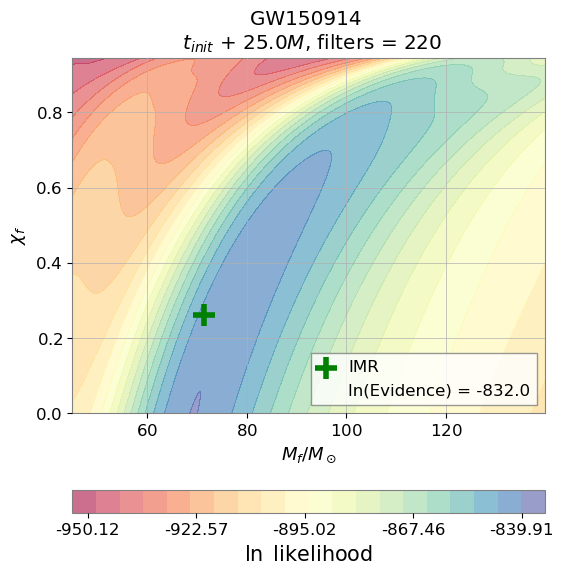

In [9]:
pl.rc('figure', figsize=(6.1, 6.6))
fig, ax = pl.subplots()
contours = ax.contourf(mass_grid, chi_grid, likelihood_data, 20, cmap='Spectral',
                       origin='lower', alpha=0.6, linestyles='--')
# dotted = ax.contour(mass_grid, chi_grid, likelihood_data, [credible_region], colors='red',
#                     linestyles='--')
ax.scatter(x=remnant_mass, y=remnant_chi, s=255, marker='+',
           c='g', linewidths=4, label='IMR')
ax.plot(np.NaN, np.NaN, '-', color='none',
        label='ln(Evidence) = %.1F' % evidence)

cbar = fig.colorbar(contours, orientation="horizontal",
                    pad=0.15, format='%3.2f')
cbar.set_label(r'$\ln$ likelihood', fontsize=15)
cbar.set_ticks(np.linspace(np.min(likelihood_data),
               np.max(likelihood_data), 5))

ax.set_title('GW150914 \n $t_{init}$ + ' + str(time_offset) +
             r'$M$, filters = ' + filter_str)
pl.legend(loc='lower right')
pl.xlabel(r'$M_f/M_\odot$', fontsize=13)
pl.ylabel(r'$\chi_f$', fontsize=13)
pl.show()

In [5]:
likelihood_data

array([[-905.18083877, -905.10605111, -905.02805832, ...,
        -907.30683794, -907.35864891, -907.41035998],
       [-905.31962323, -905.24777816, -905.17278993, ...,
        -907.22935734, -907.2813298 , -907.33320335],
       [-905.45657248, -905.38763814, -905.3156239 , ...,
        -907.15125305, -907.20338567, -907.25542044],
       ...,
       [-948.80624994, -948.73858954, -948.67421333, ...,
        -878.35681854, -878.42104083, -878.48341613],
       [-949.43845968, -949.36069313, -949.28287999, ...,
        -878.97509019, -879.06891371, -879.16112213],
       [-950.1211249 , -950.05439516, -949.98320749, ...,
        -879.17415038, -879.2936254 , -879.41214606]])

[-846.4, -845.32, -847.86, -838.71, -838.49, -835.56, -833.24, -821.38, -823.66, -826.72, -824.22, -827.11, -822.39, -827.0, -816.21, -819.19]
[-806.29, -806.09, -809.68, -807.52, -808.36, -805.5, -810.77, -808.14, -813.91, -815.94, -815.41, -817.69, -815.59, -821.53, -813.48, -818.6]
[-921.46, -886.07, -876.77, -873.94, -860.24, -844.04, -840.4, -836.75, -840.42, -839.13, -834.65, -837.79, -835.44, -836.76, -830.44, -831.99]


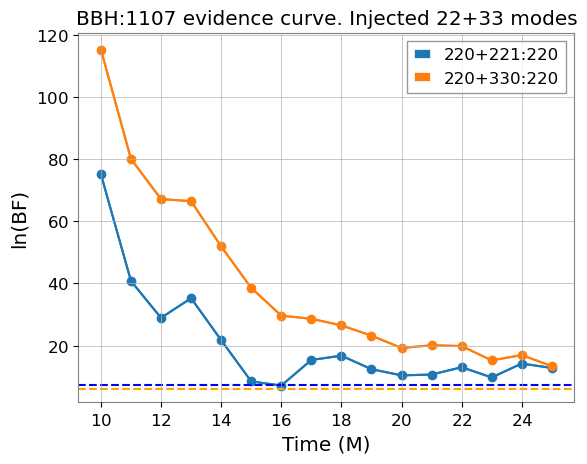

In [5]:
mode_list = ["220+221", '220+330']
ref_mode = "220"
color_arr = ['tab:blue', 'tab:orange', 'tab:green', 'tab:purple', 'tab:pink']
time_arr = []
ref_evidence = []
evidence_arr = []


files = natsorted(glob.glob(directory+ref_mode+"/BBH:1107_{}_*".format(ref_mode)))
    

for idx, name in enumerate(files):
    [likelihood_data, evidence, time_offset, filter_str, credible, \
     chi_lower, chi_upper, mass_lower, mass_upper, \
     massspace, chispace, mass_grid, chi_grid, \
     projected_mass, projected_chi] = load_data(ref_mode+'/'+files[idx].split('/')[-1])
    
    time_arr.append(time_offset)
    ref_evidence.append(evidence)

for idx0, mode in enumerate(mode_list):
    files = natsorted(glob.glob(directory+mode+"/BBH:1107_{}_*".format(mode)))
    evidence_arr = []
    for idx1, name in enumerate(files):
        [likelihood_data, evidence, time_offset, filter_str, credible, \
         chi_lower, chi_upper, mass_lower, mass_upper, \
         massspace, chispace, mass_grid, chi_grid, \
         projected_mass, projected_chi] = load_data(mode+'/'+files[idx1].split('/')[-1])

        evidence_arr.append(evidence)
    pl.plot(time_arr, np.subtract(evidence_arr, ref_evidence), label=mode+":220",
           c = color_arr[idx0])
    pl.plot(time_arr, np.subtract(evidence_arr, ref_evidence),
           c = color_arr[idx0], marker='o')
    print(evidence_arr)

print(ref_evidence)

pl.xlabel("Time (M)")
pl.ylabel("ln(BF)")
pl.axhline(7.37, ls='--', c='b')
pl.axhline(6.09, ls='--', c='orange')
pl.title("BBH:1107 evidence curve. Injected 22+33 modes")
pl.legend()
pl.show()

[-802.14, -800.92, -801.05, -801.28, -801.79, -803.65, -802.88, -802.52, -799.38, -798.17, -800.71, -802.12, -803.0, -803.61, -805.23, -804.97]
[-804.77, -804.09, -804.06, -801.94, -802.85, -806.49, -805.42, -805.79, -804.23, -801.07, -801.64, -802.71, -803.47, -801.6, -803.49, -803.22]
[-812.2, -810.09, -805.6, -802.01, -803.28, -805.92, -805.64, -806.54, -805.84, -804.31, -802.9, -803.35, -803.4, -801.9, -804.03, -802.98]


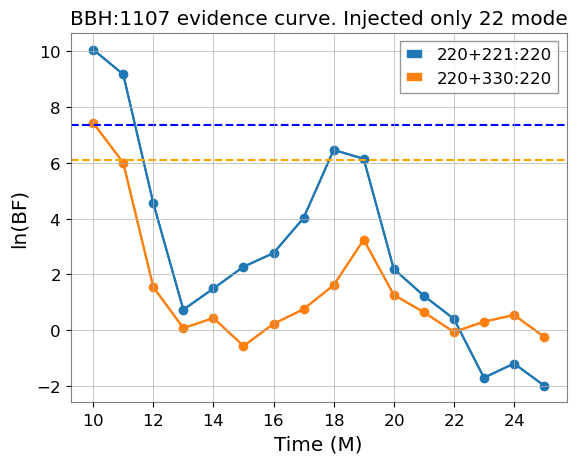

In [6]:
mode_list = ["220+221", '220+330']
ref_mode = "220"
color_arr = ['tab:blue', 'tab:orange', 'tab:green', 'tab:purple', 'tab:pink']
time_arr = []
ref_evidence = []
evidence_arr = []

files = natsorted(glob.glob(directory+ref_mode+"/BBH:1107_test_{}_*".format(ref_mode)))
for idx, name in enumerate(files):
    [likelihood_data, evidence, time_offset, filter_str, credible, \
     chi_lower, chi_upper, mass_lower, mass_upper, \
     massspace, chispace, mass_grid, chi_grid, \
     projected_mass, projected_chi] = load_data(ref_mode+'/'+files[idx].split('/')[-1])
    
    time_arr.append(time_offset)
    ref_evidence.append(evidence)

for idx0, mode in enumerate(mode_list):
    files = natsorted(glob.glob(directory+mode+"/BBH:1107_test_{}_*".format(mode)))
    evidence_arr = []
    for idx1, name in enumerate(files):
        [likelihood_data, evidence, time_offset, filter_str, credible, \
         chi_lower, chi_upper, mass_lower, mass_upper, \
         massspace, chispace, mass_grid, chi_grid, \
         projected_mass, projected_chi] = load_data(mode+'/'+files[idx1].split('/')[-1])

        evidence_arr.append(evidence)
    pl.plot(time_arr, np.subtract(evidence_arr, ref_evidence), label=mode+":220",
           c = color_arr[idx0])
    pl.plot(time_arr, np.subtract(evidence_arr, ref_evidence),
           c = color_arr[idx0], marker='o')    
    print(evidence_arr)

print(ref_evidence)

pl.xlabel("Time (M)")
pl.ylabel("ln(BF)")
pl.axhline(7.37, ls='--', c='b')
pl.axhline(6.09, ls='--', c='orange')
pl.title("BBH:1107 evidence curve. Injected only 22 mode")
pl.legend()
pl.show()

## Checking T=25M implied frequencies

In [35]:
(1126256640/4096 - 1) * 4096

1126252544.0

In [7]:
import qnm

In [8]:
mode='220+221'
[likelihood_data, evidence, time_offset, filter_str, credible, \
 chi_lower, chi_upper, mass_lower, mass_upper, \
 massspace, chispace, mass_grid, chi_grid, \
 projected_mass, projected_chi] = load_data(mode+'/BBH:1107_220+221_t=25.0M.txt')

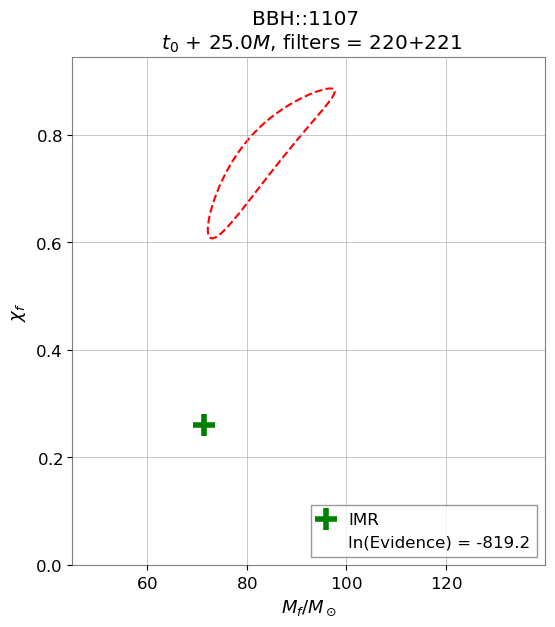

In [9]:
pl.rc('figure', figsize=(6.1, 6.6))
fig, ax = pl.subplots()
# contours = ax.contourf(mass_grid, chi_grid, likelihood_data, 20, cmap='Spectral',
#                        origin='lower', alpha=0.6, linestyles='--')
dotted = ax.contour(mass_grid, chi_grid, likelihood_data, [credible], colors = 'red', \
                   linestyles ='--')
ax.scatter(x=remnant_mass, y=remnant_chi, s=255, marker='+', 
           c='g', linewidths=4, label='IMR')
ax.plot(np.NaN, np.NaN, '-', color='none', label='ln(Evidence) = %.1F' % evidence)

# cbar=fig.colorbar(contours, orientation="horizontal", 
#                   pad=0.15, format='%3.2f')
# cbar.set_label(r'$\ln$ likelihood', fontsize=15)
# cbar.set_ticks(np.linspace(np.min(likelihood_data), np.max(likelihood_data), 5))

ax.set_title('BBH::1107 \n $t_0$ + ' + str(time_offset) +
             r'$M$, filters = ' + filter_str)
pl.legend(loc = 'lower right')
pl.xlabel(r'$M_f/M_\odot$', fontsize=13)
pl.ylabel(r'$\chi_f$', fontsize=13)
pl.show()

In [18]:
results = []
levels = [dotted]
for i in levels:
    temp0 = []
    for j in i.collections[0].get_paths():
        coords = j.vertices
        temp1 = [(rd.qnms.get_ftau(k[0], k[1], l=2,m=2,n=0),
               rd.qnms.get_ftau(k[0], k[1], l=2,m=2,n=1),
               rd.qnms.get_ftau(k[0], k[1], l=3,m=3,n=0)) for k in coords]
#         temp1.append(temp1[0])
        temp0.append(temp1)
    results.append(temp0)

/tmp/ipykernel_181534/3218890631.py:5: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  for j in i.collections[0].get_paths():


In [26]:
1/(injected_mass*np.imag(qnm.modes_cache(s=-2,l=3,m=3,n=0)(a=injected_chi)[0]))

-31046.094235798613

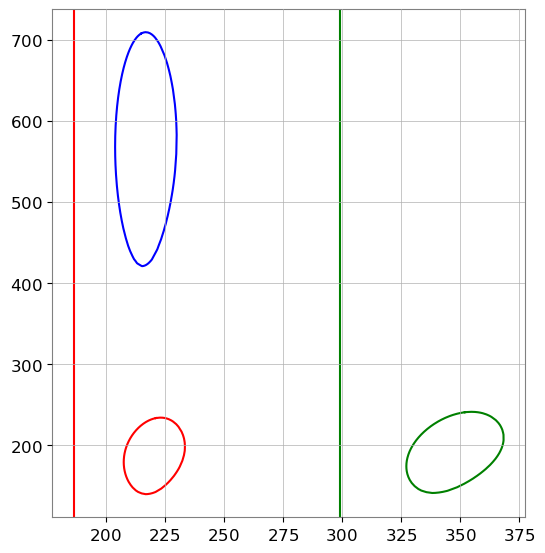

In [23]:
for idx, i in enumerate(results):
    for j in i:
        temp = np.array(j)
        pl.plot(temp[:,0,0], 1/temp[:,0,1], c='r')
        pl.plot(temp[:,1,0], 1/temp[:,1,1], c='b')
        # pl.plot(temp[:,2,0], 1/temp[:,2,1], c='g')
pl.axvline(np.real(qnm.modes_cache(s=-2,l=2,m=2,n=0)(a=injected_chi)[0])/(2*np.pi*injected_mass), c='r')
pl.axvline(np.real(qnm.modes_cache(s=-2,l=3,m=3,n=0)(a=injected_chi)[0])/(2*np.pi*injected_mass), c='g')


# print("Injected 220 freq", np.real(qnm.modes_cache(s=-2,l=2,m=2,n=0)(a=injected_chi)[0])/(2*np.pi*injected_mass))
# print("Injected 221 freq", np.real(qnm.modes_cache(s=-2,l=2,m=2,n=1)(a=injected_chi)[0])/(2*np.pi*injected_mass))
# print("Injected 330 freq", np.real(qnm.modes_cache(s=-2,l=3,m=3,n=0)(a=injected_chi)[0])/(2*np.pi*injected_mass))


pl.show()

In [ ]:
ls_arr = ['--',':']

pl.rc('figure', figsize=(12.1, 6.6))
fig, axs = pl.subplots(1,2)
contours = axs[0].contourf(mass_grid, chi_grid, likelihood_data, 20, cmap='Spectral',
                       origin='lower', alpha=0.6, linestyles='--')
dotted10 = axs[0].contour(mass_grid, chi_grid, likelihood_data, [credible_region10], colors = 'red', \
                   linestyles ='--')
dotted50 = axs[0].contour(mass_grid, chi_grid, likelihood_data, [credible_region50], colors = 'red', \
                   linestyles =':')
axs[0].errorbar(x=IMR_analysis[0], y=IMR_analysis[1], xerr=IMR_analysis[2], yerr=IMR_analysis[3], 
           c='g', label='IMR')
axs[0].plot(np.NaN, np.NaN, '-', color='none', label='ln(Evidence) = %.1F' % evidence)
axs[0].plot([], [], c='r', ls = '--', lw = 0.01, ms=0.01, label='10% contour')
axs[0].plot([], [], c='r', ls = ':', label='50% contour')

# colorbar
cbar=fig.colorbar(contours, orientation="horizontal", 
                  pad=0.15, format='%3.2f')
cbar.set_label(r'$\ln$ likelihood', fontsize=15)
cbar.set_ticks(np.linspace(np.min(likelihood_data), np.max(likelihood_data), 5))

axs[0].set_xlabel(r'$M_f/M_\odot$', fontsize=13)
axs[0].set_ylabel(r'$\chi_f$', fontsize=13)
axs[0].legend(loc = 'lower right', fontsize=8, handlelength=6)

axs[0].set_title('BBH:1107 \n $t_{init}$ + ' + str(time_offset) +
             r'$M_\odot$, filters = ' + filter_str)
# pl.savefig('./gif_imgs/220+1_t={}M.png'.format(time_offset))

for idx, i in enumerate(results):
    for j in i:
        temp = np.array(j)
        axs[1].plot(temp[:,0,0], 1/temp[:,0,1], c='r', ls=ls_arr[idx])
        axs[1].plot(temp[:,1,0], 1/temp[:,1,1], c='g', ls=ls_arr[idx])
#         axs[1].plot(temp[:,2,0], 1/temp[:,2,1], c='blue', ls=ls_arr[idx])
#         axs[1].plot(temp[:,3,0], 1/temp[:,3,1], c='orange', ls=ls_arr[idx])

l, = pl.plot([], [], c='r', label='220')
l, = pl.plot([], [], c='green', label='221')
l, = pl.plot([], [], c='b', label='210')
# l, = pl.plot([], [], c='teal', label='211')
# l, = pl.plot([], [], c='orange', label='222')
pl.legend(loc = 'upper left')
handles, labels = pl.gca().get_legend_handles_labels()
# l, = pl.plot([], [], c='k', ls = '-', label='IMR')
# l, = pl.plot([], [], c='k', ls = '--', label='10% contour')
# l, = pl.plot([], [], c='k', ls = ':', label='50% contour')
pl.legend(loc='upper left')
axs[1].set_title('Implied $f$ and $\gamma$ from 10% and 50% contours')
pl.xlabel(r'$f/$Hz')
pl.ylabel(r'$\gamma$/Hz')

In [20]:
idx = np.unravel_index(np.argmax(likelihood_data, axis=None), likelihood_data.shape)
maxL_mass = qnm_filter.Filter.mass_unit(mass_grid[idx])
maxL_chi = chi_grid[idx]

injected_mass = qnm_filter.Filter.mass_unit(remnant_mass)
injected_chi = remnant_chi

print("Injected properties:", remnant_mass, remnant_chi)
print("Max L properties:", mass_grid[idx], chi_grid[idx])

Injected properties: 71.41 0.261
Max L properties: 85.2 0.795


In [23]:
print("Injected 220 freq", np.real(qnm.modes_cache(s=-2,l=2,m=2,n=0)(a=injected_chi)[0])/(2*np.pi*injected_mass))
print("Injected 221 freq", np.real(qnm.modes_cache(s=-2,l=2,m=2,n=1)(a=injected_chi)[0])/(2*np.pi*injected_mass))
print("Injected 330 freq", np.real(qnm.modes_cache(s=-2,l=3,m=3,n=0)(a=injected_chi)[0])/(2*np.pi*injected_mass))

print("MaxL 220 freq", np.real(qnm.modes_cache(s=-2,l=2,m=2,n=0)(a=maxL_chi)[0])/(2*np.pi*maxL_mass))
print("MaxL 221 freq", np.real(qnm.modes_cache(s=-2,l=2,m=2,n=1)(a=maxL_chi)[0])/(2*np.pi*maxL_mass))
print("MaxL 330 freq", np.real(qnm.modes_cache(s=-2,l=3,m=3,n=0)(a=maxL_chi)[0])/(2*np.pi*maxL_mass))

Injected 220 freq 186.62713816700276
Injected 221 freq 176.6990215486541
Injected 330 freq 299.0944854739034
MaxL 220 freq 221.035560527481
MaxL 221 freq 217.89554306305726
MaxL 330 freq 347.866923762171
